This Notebook illustrates the usage of the OpenMC Python API's generic eigenvalue search capability.  In this Notebook, we will do a critical boron concentration search of a typical PWR pin cell.

To use the search functionality, we must create a function which creates our model according to the input parameter we wish to search for (in this case, the boron concentration).  

This notebook will first create that function, and then, run the search.

In [1]:
# Initialize third-party libraries and the OpenMC Python API
import matplotlib.pyplot as plt
import numpy as np

import openmc
import openmc.model

%matplotlib inline

# Create Parametrized Model

To perform the search we will use the `openmc.search_for_keff` function.  This function requires a different function be defined which creates an parametrized model to analyze. This model is required to be stored in an `openmc.model.Model` object. The first parameter of this function will be modified during the search process for our critical eigenvalue.

Our model will be a pin-cell from the [Multi-Group Mode Part II](http://docs.openmc.org/en/latest/examples/mg-mode-part-ii.html) assembly, except this time the entire model building process will be contained within a function, and the Boron concentration will be parametrized.

In [2]:
# Create the model. `ppm_Boron` will be the parametric variable.

def build_model(ppm_Boron):
    # Create the pin materials
    fuel = openmc.Material(name='1.6% Fuel')
    fuel.set_density('g/cm3', 10.31341)
    fuel.add_element('U', 1., enrichment=1.6)
    fuel.add_element('O', 2.)

    zircaloy = openmc.Material(name='Zircaloy')
    zircaloy.set_density('g/cm3', 6.55)
    zircaloy.add_element('Zr', 1.)

    water = openmc.Material(name='Borated Water')
    water.set_density('g/cm3', 0.741)
    water.add_element('H', 2.)
    water.add_element('O', 1.)

    # Include the amount of boron in the water based on the ppm,
    # neglecting the other constituents of boric acid
    water.add_element('B', ppm_Boron * 1e-6)
    
    # Instantiate a Materials object
    materials = openmc.Materials([fuel, zircaloy, water])
    
    # Create cylinders for the fuel and clad
    fuel_outer_radius = openmc.ZCylinder(r=0.39218)
    clad_outer_radius = openmc.ZCylinder(r=0.45720)

    # Create boundary planes to surround the geometry
    min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
    max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
    min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
    max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')

    # Create fuel Cell
    fuel_cell = openmc.Cell(name='1.6% Fuel')
    fuel_cell.fill = fuel
    fuel_cell.region = -fuel_outer_radius

    # Create a clad Cell
    clad_cell = openmc.Cell(name='1.6% Clad')
    clad_cell.fill = zircaloy
    clad_cell.region = +fuel_outer_radius & -clad_outer_radius

    # Create a moderator Cell
    moderator_cell = openmc.Cell(name='1.6% Moderator')
    moderator_cell.fill = water
    moderator_cell.region = +clad_outer_radius & (+min_x & -max_x & +min_y & -max_y)

    # Create root Universe
    root_universe = openmc.Universe(name='root universe', universe_id=0)
    root_universe.add_cells([fuel_cell, clad_cell, moderator_cell])

    # Create Geometry and set root universe
    geometry = openmc.Geometry(root_universe)
    
    # Finish with the settings file
    settings = openmc.Settings()
    settings.batches = 300
    settings.inactive = 20
    settings.particles = 1000
    settings.run_mode = 'eigenvalue'

    # Create an initial uniform spatial source distribution over fissionable zones
    bounds = [-0.63, -0.63, -10, 0.63, 0.63, 10.]
    uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
    settings.source = openmc.source.Source(space=uniform_dist)

    # We dont need a tallies file so dont waste the disk input/output time
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geometry, materials, settings)
    
    return model

# Search for the Critical Boron Concentration

To perform the search we imply call the `openmc.search_for_keff` function and pass in the relvant arguments.  For our purposes we will be passing in the model building function (`build_model` defined above), a bracketed range for the expected critical Boron concentration (1,000 to 2,500 ppm), the tolerance, and the method we wish to use. 

Instead of the bracketed range we could have used a single initial guess, but have elected not to in this example. Finally, due to the high noise inherent in using as few histories as are used in this example, our tolerance on the final keff value will be rather large (1.e-2) and a bisection method will be used for the search.

In [3]:
# Perform the search
crit_ppm, guesses, keffs = openmc.search_for_keff(build_model, bracket=[1000., 2500.],
                                                  tol=1e-2, bracketed_method='bisect',
                                                  print_iterations=True)

print('Critical Boron Concentration: {:4.0f} ppm'.format(crit_ppm))

/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 1; Guess of 1.00e+03 produced a keff of 1.08853 +/- 0.00158


/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 2; Guess of 2.50e+03 produced a keff of 0.95372 +/- 0.00148


/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 3; Guess of 1.75e+03 produced a keff of 1.01328 +/- 0.00169


/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 4; Guess of 2.12e+03 produced a keff of 0.98150 +/- 0.00158


/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 5; Guess of 1.94e+03 produced a keff of 0.99886 +/- 0.00146


/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 6; Guess of 1.84e+03 produced a keff of 1.00759 +/- 0.00162


/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 7; Guess of 1.89e+03 produced a keff of 1.00063 +/- 0.00166


/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 8; Guess of 1.91e+03 produced a keff of 0.99970 +/- 0.00150


/home/romano/openmc/openmc/mixin.py:71: IDWarning: Another Universe instance already exists with id=0.
  warn(msg, IDWarning)


Iteration: 9; Guess of 1.90e+03 produced a keff of 0.99935 +/- 0.00164
Critical Boron Concentration: 1902 ppm


Finally, the `openmc.search_for_keff` function also provided us with `List`s of the guesses and corresponding keff values generated during the search process with OpenMC. Let's use that information to make a quick plot of the value of keff versus the boron concentration.

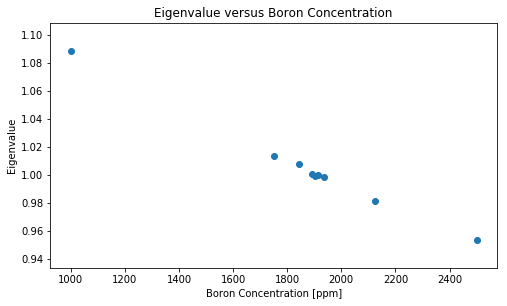

In [4]:
plt.figure(figsize=(8, 4.5))
plt.title('Eigenvalue versus Boron Concentration')
# Create a scatter plot using the mean value of keff
plt.scatter(guesses, [keffs[i].nominal_value for i in range(len(keffs))])
plt.xlabel('Boron Concentration [ppm]')
plt.ylabel('Eigenvalue')
plt.show()

We see a nearly linear reactivity coefficient for the boron concentration, exactly as one would expect for a pure 1/v absorber at small concentrations.